In [1]:
import numpy as np
import pandas as pd
import datetime, time
from datetime import date, timedelta
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:

train_file = 'input/train.csv'
test_file = 'input/test.csv'
store_file = 'input/store.csv'


In [3]:
store = pd.read_csv(store_file)

## Process Store data ##
1. CompetitionDistance field has three empty records. To fill the max distance value for those records. Because of more far has less effect. 
2. CompetitionOpenSinceMonth and CompetitionOpenSinceYear fill with minimum value. Because of minimum value mean for competition store open time is the early and less current effect. 
3. Promo2SinceWeek, Promo2SinceYear, and PromoInterval fields are filled with 0 for NaN value.

In [4]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [6]:
store.fillna(store.min()['CompetitionOpenSinceMonth':'CompetitionOpenSinceYear'], inplace=True)

In [7]:
store = store.fillna(store.max()['CompetitionDistance':'CompetitionDistance'])

In [1]:
#Promo2SinceWeek,Promo2SinceYear,PromoInterval fill 0 for NaN value.
store.fillna(0, inplace=True)

NameError: name 'store' is not defined

In [9]:
x = store['CompetitionDistance']
x.count()

1115

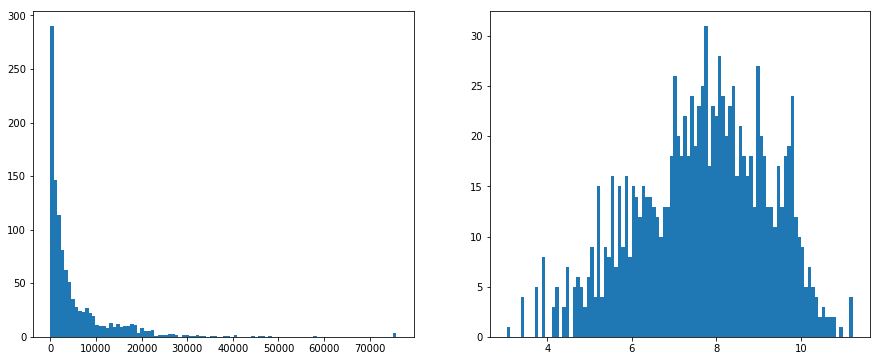

In [10]:
x = store['CompetitionDistance']
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.hist(x,100)

plt.subplot(122)
plt.hist(np.log1p(x),100)

plt.show()

1. Try to discretize the ComparisonDistance, such as 100m interval, and also use 1km, 3km, and so on, but I found the best method is using the CompetitionDistance log value.
2. I also compared log value and the original value. The original value has a little improvment. The value of RMSPE has an increase of 0.0002.

Apply _**Label encode**_ for the "StoreType" and "Assortment"

In [13]:
store['StoreType'] = store['StoreType'].map({'a':0, 'b':1, 'c':2, 'd':3})
store['Assortment'] = store['Assortment'].map({'a':0, 'b':1, 'c':2, 'd':3})

In [14]:
store['CompetitionOpenSinceYear'].sort_values().unique()

array([1900., 1961., 1990., 1994., 1995., 1998., 1999., 2000., 2001.,
       2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009., 2010.,
       2011., 2012., 2013., 2014., 2015.])

The competition store earliest time is 1900, then is 1961. And the nearest time is 2015. In this project, the store data start from the 2013 year. So we need to consider the effect of the competition start time. I use 1/1/2000 year as the base time to calculate days from the competition start time. if the time early than the year 2000, I will set as 2000.

In [15]:
from datetime import date, timedelta

def get_competition_open_day(row):
    openyear = int(row['CompetitionOpenSinceYear'])
    if openyear < 2000:
        openyear = 2000 
    openmonth = int(row['CompetitionOpenSinceMonth'])
    open_day = date(openyear, openmonth, 1)
    base_day = date(2000,1,1) #base day is 2000-1-1
    
    return (open_day - base_day).days  # get days from 2000-1-1

In [16]:
store['OpenedDays'] = store.apply(get_competition_open_day,axis =1)
#store = store.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'], axis=1)

In [17]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,OpenedDays
0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,3166
1,2,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2861
2,3,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2526
3,4,2,2,620.0,9.0,2009.0,0,0.0,0.0,0,3531
4,5,0,0,29910.0,4.0,2015.0,0,0.0,0.0,0,5569


To set the "PromoInterval" from month to integer value

In [18]:
month_dict = {'Jan':1,'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8,'Sept':9,'Oct':10, 'Nov':11, 'Dec':12}

In [19]:
interval = store['PromoInterval'].values.tolist()

for key, item in enumerate(interval):
    if item != 0:
        if len(item.split(',')) !=4:
            print (key,item)

In [20]:
store['PromoInterval'].iloc[2]

row = store.iloc[2]
row['PromoInterval'].split(',')

['Jan', 'Apr', 'Jul', 'Oct']

After check, all the PromoInterval fields are having four month. I convert the PromoInterval to four new integer parameters: Interval1 - Interval4. For those no Promo2 promotion records, I set these new parameters as value 0.

In [21]:
def change_to_intervals(row):
    interval1 = interval2 = interval3 =interval4 = 0
    if row['Promo2'] != 0:
        months = row['PromoInterval'].split(',')
        interval1 = month_dict[months[0]]
        interval2 = month_dict[months[1]]
        interval3 = month_dict[months[2]]
        interval4 = month_dict[months[3]]
        
    return interval1, interval2, interval3, interval4

In [22]:
store['Interval1'] = np.nan
store['Interval2'] = np.nan
store['Interval3'] = np.nan
store['Interval4'] = np.nan

store['Interval1'], store['Interval2'],store['Interval3'],store['Interval4'] = zip(*store.apply(change_to_intervals,axis=1))
store = store.drop('PromoInterval', axis=1)
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,OpenedDays,Interval1,Interval2,Interval3,Interval4
0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,3166,0,0,0,0
1,2,0,0,570.0,11.0,2007.0,1,13.0,2010.0,2861,1,4,7,10
2,3,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,2526,1,4,7,10
3,4,2,2,620.0,9.0,2009.0,0,0.0,0.0,3531,0,0,0,0
4,5,0,0,29910.0,4.0,2015.0,0,0.0,0.0,5569,0,0,0,0


In [23]:
store['Promo2SinceYear'].unique()

array([   0., 2010., 2011., 2012., 2009., 2014., 2015., 2013.])

The Promo2 value is start from 2010 year. I convert it value as days from the day 1/1/2000. For those records without Promo2, I set it value as -1.

In [24]:
import datetime, time

def convert_promo2_startday(row):
    if row['Promo2'] == 0:
        promo2_day = -1
    else:
        weekofyear_string = '%d-W%d'%(row['Promo2SinceYear'],row['Promo2SinceWeek'])
        day_time = datetime.datetime.strptime(weekofyear_string + '-0', "%Y-W%U-%w")
        promo2_open_day = date(day_time.year, day_time.month, day_time.day)
        base_day = date(2000,1,1)
        
        promo2_day = (promo2_open_day - base_day).days
    return promo2_day

In [25]:
store['Promo2Days'] = store.apply(convert_promo2_startday,axis=1)
#store = store.drop(['Promo2SinceWeek', 'Promo2SinceYear'], axis =1)
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,OpenedDays,Interval1,Interval2,Interval3,Interval4,Promo2Days
0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,3166,0,0,0,0,-1
1,2,0,0,570.0,11.0,2007.0,1,13.0,2010.0,2861,1,4,7,10,3739
2,3,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,2526,1,4,7,10,4110
3,4,2,2,620.0,9.0,2009.0,0,0.0,0.0,3531,0,0,0,0,-1
4,5,0,0,29910.0,4.0,2015.0,0,0.0,0.0,5569,0,0,0,0,-1


## Process Train.csv ##

In [26]:
train = pd.read_csv(train_file, parse_dates = True)

C:\Users\minan\AppData\Local\conda\conda\envs\tf14\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [28]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


#### To query calender, the day 1/1/2013 is Tuesday. The related DayOfWeek field value is 2. So it means in Train data, the DayOfWeek is start from Sunday, value is 0 ####

Apply **_Label encoder_** for StateHoliday

In [29]:
train['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [30]:
train['SchoolHoliday'].unique()

array([1, 0], dtype=int64)

In [31]:
train['StateHoliday'] = train['StateHoliday'].astype(str)
train['StateHoliday'] = train['StateHoliday'].map({'0':0, 'a':1, 'b':2, 'c':3})

In [32]:
train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [33]:
train['Date']= pd.to_datetime(train['Date'])
train = train.sort_values('Date')

Conver the Date's value as days from 1/1/2000

In [34]:
def get_current_day(row):
    tmp = row['Date']
    today = date(tmp.year, tmp.month, tmp.day)
    base_day = date(2000,1,1)
    return (today - base_day).days

In [35]:
train['Currentday'] = train.apply(get_current_day,axis=1)
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Currentday
1017208,1115,2,2013-01-01,0,0,0,0,1,1,4749
1016473,379,2,2013-01-01,0,0,0,0,1,1,4749
1016472,378,2,2013-01-01,0,0,0,0,1,1,4749
1016471,377,2,2013-01-01,0,0,0,0,1,1,4749
1016470,376,2,2013-01-01,0,0,0,0,1,1,4749


In [36]:
train['Year'] = train['Date'].apply(lambda x: x.year)
train['Month'] = train['Date'].apply(lambda x: x.month)
train['Day'] = train['Date'].apply(lambda x: x.day)
train['WeekofYear'] = train['Date'].apply(lambda x: x.week)
train['DayofYear'] = train['Date'].apply(lambda x: x.dayofyear)
#train = train.drop(['Date'], axis=1)
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Currentday,Year,Month,Day,WeekofYear,DayofYear
1017208,1115,2,2013-01-01,0,0,0,0,1,1,4749,2013,1,1,1,1
1016473,379,2,2013-01-01,0,0,0,0,1,1,4749,2013,1,1,1,1
1016472,378,2,2013-01-01,0,0,0,0,1,1,4749,2013,1,1,1,1
1016471,377,2,2013-01-01,0,0,0,0,1,1,4749,2013,1,1,1,1
1016470,376,2,2013-01-01,0,0,0,0,1,1,4749,2013,1,1,1,1


### Process StateHoliday and SchoolHoliday ###
1. Add new parameters for differentiate before StateHoliday and after StateHoliday.
2. Add new parameters for differentiate the before SchoolHoliday, in the SchoolHoliday and after the SchoolHoliday.

### Remove records with 0 value of the Sales ###

In [37]:
zero_sales = train.loc[train['Sales'] == 0].index

In [38]:
zero_sales

Int64Index([1017208, 1016473, 1016472, 1016471, 1016470, 1016469, 1016468,
            1016467, 1016466, 1016465,
            ...
               4751,    5335,    3636,    4220,    2521,    3105,    1406,
               1990,     291,     875],
           dtype='int64', length=172871)

In [39]:
not_open = train.loc[train['Open'] == 0].index.values

In [40]:
len(zero_sales) - len(not_open)

54

The recoreds with 0 Sales are 54 more than those not opened records. I remove those abnormal records.

In [41]:
zero_sales_rows = zero_sales.tolist()

In [42]:
train.drop(zero_sales_rows, axis=0, inplace=True)

### Delete the Outlier data###

In [43]:
def get_outlier_IQR(sales):
    Q1 = np.percentile(sales, 25)
    Q3 = np.percentile(sales, 75)
    step = 1.5 * (Q3 - Q1)
    return (~((sales>=Q1-step) & (sales<=Q3+step)))

In [44]:
for i in store['Store'].unique():
    train.loc[(train['Store'] == i) , 'Outlier'] = \
        get_outlier_IQR(train.loc[(train['Store'] == i)]['Sales'])

In [46]:
train = train.loc[train['Outlier'] == False]

### Merge train and store data ###

In [47]:
train = pd.merge(train,store, on='Store')

#### Get the value of the Day before promo2, Day in promo2, Day after promo2 ####

In [48]:
from datetime import date
import calendar

#Get days afer previous promo2 interval and  Days before next promo2 interval
# need consider next year and previous year
def get_before_and_after_promo2_days(year,month,day,previous_interval,next_interval, if_next_year=0, if_previou_year=0):
    today = date(year,month,day)
    
    next_promo2_day = date(year+ if_next_year, next_interval, 1)
    
    last_day_of_month = calendar.monthrange(year+if_previou_year, previous_interval)[1]
    previous_promo2_day = date(year+if_previou_year, previous_interval, last_day_of_month)
    
    day_before_promo2 = (next_promo2_day - today).days
    day_after_promo2 = (today - previous_promo2_day).days
    
    return day_before_promo2, day_after_promo2

In [49]:
def process_promo2_days_for_each_row(record):
    day_before_promo2 = -3
    day_in_promo2 = -3
    day_after_promo2 = -3
        
    if record['Promo2'] == 0:
        day_before_promo2 = -2
        day_in_promo2 = -2
        day_after_promo2 = -2
        return day_before_promo2, day_in_promo2, day_after_promo2
    
    year = record['Year']
    month = record['Month']
    day = record['Day']
    week = record['WeekofYear']
    if record['Currentday'] < record['Promo2Days']:
        day_before_promo2 = (record['Promo2Days'] - record['Currentday'])
        day_in_promo2 = -1
        day_after_promo2 = -1
    else:
        # Just in the promo2 start year and week
        if week == record['Promo2SinceWeek'] and year == record['Promo2SinceYear']:
            day_before_promo2 = -1
            day_in_promo2 = record['Currentday'] - record['Promo2Days']
            day_after_promo2 = -1
        else:
            # after promo2 start time, check if is in promo2 months
            if month == record['Interval1'] or month == record['Interval2'] \
            or month == record['Interval3'] or month == record['Interval4']:
                day_before_promo2 = -1
                day_in_promo2 = (day-1) # start from 0
                day_after_promo2 = -1
            else:
                if month > record['Interval4']:
                    previous_promo2_day, next_promo2_day = \
                    get_before_and_after_promo2_days(year,month,day,record['Interval4'], record['Interval1'], if_next_year=1)

                    day_before_promo2 = next_promo2_day
                    day_in_promo2 = -1
                    day_after_promo2 = (previous_promo2_day)
                elif month > record['Interval3']:
                    previous_promo2_day, next_promo2_day = \
                    get_before_and_after_promo2_days(year,month,day,record['Interval3'], record['Interval4'], if_next_year=0)

                    day_before_promo2 = next_promo2_day
                    day_in_promo2 = -1
                    day_after_promo2 = previous_promo2_day
                elif month > record['Interval2']:
                    previous_promo2_day, next_promo2_day = \
                    get_before_and_after_promo2_days(year,month,day,record['Interval2'], record['Interval3'], if_next_year=0)

                    day_before_promo2 = next_promo2_day
                    day_in_promo2 = -1
                    day_after_promo2 = previous_promo2_day
                elif month > record['Interval1']:
                    previous_promo2_day, next_promo2_day = \
                    get_before_and_after_promo2_days(year,month,day,record['Interval1'], record['Interval2'], if_next_year=0)

                    day_before_promo2 = next_promo2_day
                    day_in_promo2 = -1
                    day_after_promo2 = previous_promo2_day
                else:
                    previous_promo2_day, next_promo2_day = \
                    get_before_and_after_promo2_days(year,month,day,record['Interval4'], record['Interval1'], if_previou_year=-1)

                    day_before_promo2 = next_promo2_day
                    day_in_promo2 = -1
                    day_after_promo2 = previous_promo2_day
    
    return day_before_promo2, day_in_promo2, day_after_promo2

In [50]:
train['DaybeforePromo2'] = np.nan
train['DayinPromo2'] = np.nan
train['DayafterPromo2'] = np.nan

train['DaybeforePromo2'], train['DayinPromo2'],train['DayafterPromo2'] = zip(*train.apply(process_promo2_days_for_each_row,axis=1))

train = train.drop(['Promo2SinceWeek','Promo2SinceYear','Interval1','Interval2','Interval3','Interval4', 'Promo2Days'], axis=1)
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Currentday,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,OpenedDays,DaybeforePromo2,DayinPromo2,DayafterPromo2
0,353,2,2013-01-01,3139,820,1,0,1,1,4749,...,1,1,900.0,1.0,1900.0,1,0,96,-1,-1
1,353,3,2013-01-02,2686,835,1,0,0,1,4750,...,1,1,900.0,1.0,1900.0,1,0,95,-1,-1
2,353,4,2013-01-03,2628,815,1,0,0,1,4751,...,1,1,900.0,1.0,1900.0,1,0,94,-1,-1
3,353,5,2013-01-04,2677,856,1,0,0,1,4752,...,1,1,900.0,1.0,1900.0,1,0,93,-1,-1
4,353,6,2013-01-05,2224,719,1,0,0,0,4753,...,1,1,900.0,1.0,1900.0,1,0,92,-1,-1


#### The effect of the competition store started day for the Sales: ####
I added two parameters, one is using for recording the flag for before competition start day; another is using for recording the flag for equal or later than competition start day.  

Early than competition the start day:
1. If early than half year, set value 1.
2. If early than one month, set value 10.
3. If early than one week, set value 100.
4. If early than in one week, set value 1000.

Equal or later the start day:
1. If current day is in same week as the start day, set value 1000;
2. If current day is later in one month, set value 100;
3. If current day is later in half year, set value 10;
4. If current day is later more than half year, set value 1;

In [51]:
def set_competition_level_beforeAndAfter(row):
    before_level = 0
    after_level = 0
    
    days = row['Currentday'] - row['OpenedDays']
    if days <= -183:
        before_level = 1
    elif days <= -31:
        before_level = 10
    elif days <= -7:
        before_level = 100
    elif days < 0:
        before_level = 1000
    elif days <=7:
        after_level = 1000
    elif days <=31:
        after_level = 100
    elif days <= 183:
        after_level = 10
    else:
        afer_level = 1
    
    return before_level, after_level

In [52]:
train['Competition_level_before'] = np.nan
train['Competition_level_after'] = np.nan
train['Competition_level_before'], train['Competition_level_after'] = zip(*train.apply(set_competition_level_beforeAndAfter,axis=1))

train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Currentday,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,OpenedDays,DaybeforePromo2,DayinPromo2,DayafterPromo2,Competition_level_before,Competition_level_after
0,353,2,2013-01-01,3139,820,1,0,1,1,4749,...,900.0,1.0,1900.0,1,0,96,-1,-1,0,0
1,353,3,2013-01-02,2686,835,1,0,0,1,4750,...,900.0,1.0,1900.0,1,0,95,-1,-1,0,0
2,353,4,2013-01-03,2628,815,1,0,0,1,4751,...,900.0,1.0,1900.0,1,0,94,-1,-1,0,0
3,353,5,2013-01-04,2677,856,1,0,0,1,4752,...,900.0,1.0,1900.0,1,0,93,-1,-1,0,0
4,353,6,2013-01-05,2224,719,1,0,0,0,4753,...,900.0,1.0,1900.0,1,0,92,-1,-1,0,0


To calculate：
1. Average sales per store per day.
2. Customer number per store per day.
3. Average sales per customer per day per store.

In [54]:
### Get total sales, customers and open days per store
train['logSales'] = np.log1p(train['Sales'])
train['logCustomers'] = np.log1p(train['Customers'])
store_data_sales = train.groupby([train['Store']])['logSales'].sum()
store_data_customers = train.groupby([train['Store']])['logCustomers'].sum()
store_data_open = train.groupby([train['Store']])['Open'].count()

### Calculate sales per day, customers per day and sales per customers per day
store_data_sales_per_day = store_data_sales / store_data_open
store_data_customers_per_day = store_data_customers / store_data_open
store_data_sales_per_customer_per_day = store_data_sales_per_day / store_data_customers_per_day

store = pd.merge(store, store_data_sales_per_day.reset_index(name='SalesPerDay'), how='left', on=['Store'])
store = pd.merge(store, store_data_customers_per_day.reset_index(name='CustomersPerDay'), how='left', on=['Store'])
store = pd.merge(store, store_data_sales_per_customer_per_day.reset_index(name='SalesPerCustomersPerDay'), how='left', on=['Store'])

store_features = ['Store', 'SalesPerDay', 'CustomersPerDay', 'SalesPerCustomersPerDay']

train = pd.merge(train, store[store_features], how='left', on=['Store'])

In [56]:
feature_list = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekofYear', 'StoreType', 
                'Assortment','Promo2', 'CompetitionDistance', 'Competition_level_before','Competition_level_after','DaybeforePromo2','DayinPromo2',
                'DayafterPromo2','SalesPerDay', 'CustomersPerDay', 'SalesPerCustomersPerDay']

Use the Sales column as Label

In [57]:
#Use last six weeks data as validation set

#train['Sales'] = train['Sales'].apply(lambda x: np.log1p(x))
#max_log_sales = train['Sales'].max()

test_records = train[train['Date'] >= '2015-06-19']
train_records = train[train['Date'] < '2015-06-19']


X_train = train_records[feature_list]
y_train = train_records['logSales']

X_test = test_records[feature_list]
y_test = test_records['logSales']

In [60]:
# Thanks to Chenglong Chen for providing this in the forum
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [61]:
print('training data processed')

params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.01, #0.3, 0.1, 0.01, 0.0096
          "max_depth": 8, #10, 8
          "subsample": 0.9, #0.9, 0.5
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 42
          }
num_boost_round = 36000

print("Train a XGBoost model")

dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
evals_result_list = {}
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, evals_result = evals_result_list,early_stopping_rounds=300, feval=rmspe_xg, verbose_eval=300)
#gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, feval=rmspe_xg, verbose_eval=True)


training data processed
Train a XGBoost model
[0]	train-rmse:8.1736	eval-rmse:8.18544	train-rmspe:0.999863	eval-rmspe:0.999865
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 300 rounds.
[300]	train-rmse:0.428332	eval-rmse:0.428876	train-rmspe:0.340502	eval-rmspe:0.339727
[600]	train-rmse:0.132118	eval-rmse:0.144991	train-rmspe:0.138538	eval-rmspe:0.150998
[900]	train-rmse:0.122772	eval-rmse:0.140398	train-rmspe:0.131993	eval-rmspe:0.150295
[1200]	train-rmse:0.118099	eval-rmse:0.13737	train-rmspe:0.126926	eval-rmspe:0.147111
[1500]	train-rmse:0.114198	eval-rmse:0.134725	train-rmspe:0.122668	eval-rmspe:0.144278
[1800]	train-rmse:0.110961	eval-rmse:0.132584	train-rmspe:0.11917	eval-rmspe:0.141668
[2100]	train-rmse:0.108082	eval-rmse:0.130494	train-rmspe:0.115963	eval-rmspe:0.138946
[2400]	train-rmse:0.105565	eval-rmse:0.12865	train-rmspe:0.113214	eval-rmspe:0.136632
[2700]	train-rmse:0.103388	eval-rmse:

In [62]:
print("Validating")
yhat = gbm.predict(xgb.DMatrix(X_test))
error = rmspe(np.expm1(y_test), np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

Validating
RMSPE: 0.109707


In [63]:
predict_result = pd.DataFrame()
predict_result['Store'] = test_records['Store']
predict_result['Date'] = test_records['Date']
predict_result['PredictionValue'] = np.expm1(yhat)
predict_result['Sales'] = np.expm1(y_test)
predict_result = predict_result.reset_index(drop=True)

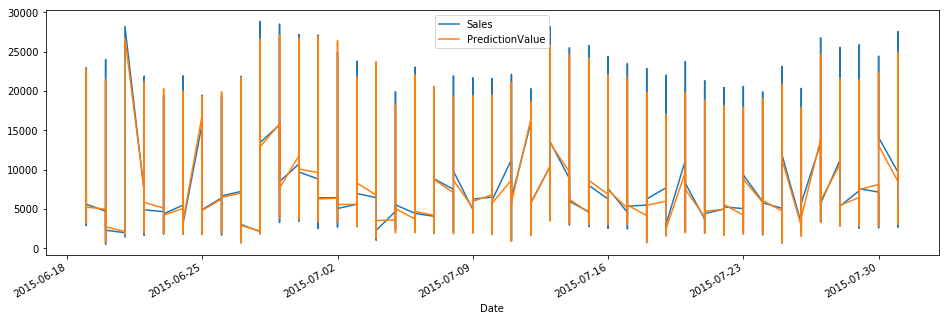

In [64]:
tmp = predict_result[['Date','Sales','PredictionValue']]
ax = tmp.set_index('Date').plot(figsize=(16,5))
plt.show()

In [65]:
store_list = predict_result['Store'].unique()
store_list

array([ 353,  335,  494, ...,  349, 1081,  103], dtype=int64)

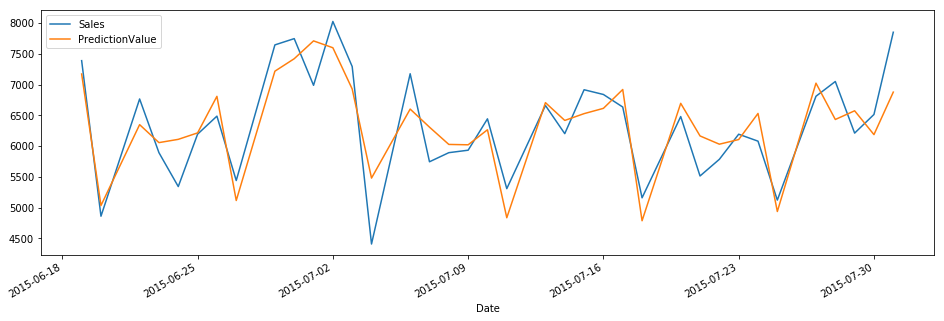

In [66]:
store_353 = predict_result[predict_result['Store']==353][['Date','Sales','PredictionValue']]
ax = store_353.set_index('Date').plot(figsize=(16,5))
plt.show()

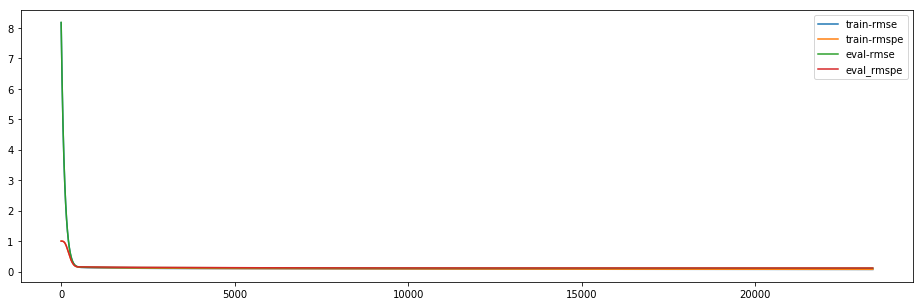

In [67]:
evals_result = pd.DataFrame()
evals_result['train-rmse'] = evals_result_list['train']['rmse']
evals_result['train-rmspe'] = evals_result_list['train']['rmspe']
evals_result['eval-rmse'] = evals_result_list['eval']['rmse']
evals_result['eval_rmspe'] = evals_result_list['eval']['rmspe']

evals_result.plot(figsize = (16, 5))
plt.show()

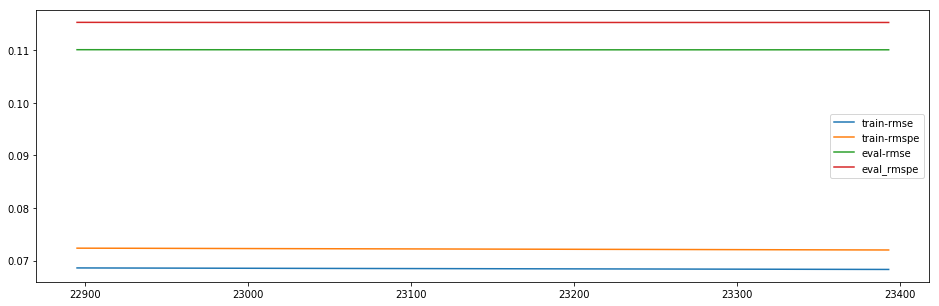

In [68]:
tmp = evals_result.iloc[-500:-1]
tmp.plot(figsize = (16, 5))
plt.show()

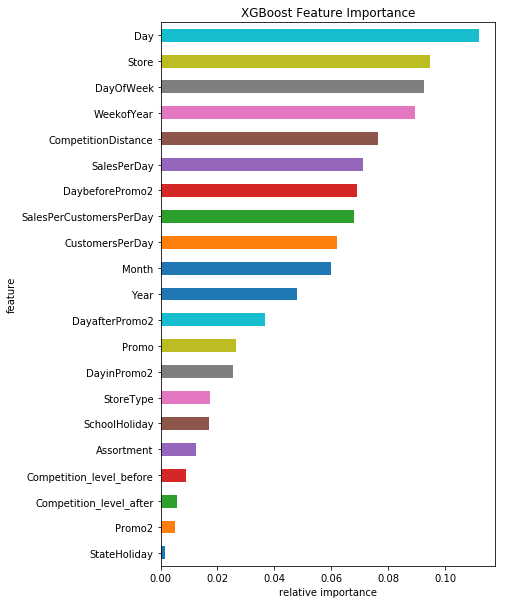

In [69]:
# XGB feature importances
# Based on https://www.kaggle.com/mmueller/liberty-mutual-group-property-inspection-prediction/xgb-feature-importance-python/code
import operator

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

create_feature_map(feature_list)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)
plt.show()

## Process Test data ##

In [70]:
test = pd.read_csv(test_file)

In [71]:
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [72]:
null_data = test[test['Open'].isnull()]
null_data

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


Those records are neither State Holiday or School Holiday. So I set the Open field as value 1.

In [73]:
test.fillna(1, inplace=True)
test.isnull().sum()

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [74]:
# Label Encode
test['StateHoliday'] = test['StateHoliday'].astype(str)
test['StateHoliday'] = test['StateHoliday'].map({'0':0, 'a':1, 'b':2, 'c':3})

#Process Date
test['Date']= pd.to_datetime(test['Date'])

# Convert Date to days from year 1970
current_days = []
records_count = test['Date'].count()

for i in range(records_count):
    temp = test['Date'][i]
    currenttime = (temp.year, temp.month, temp.day,0,0,0, 0,0,0)
    days = time.mktime(currenttime)/3600/24
    current_days.append(int(days))

test['Currentday'] = current_days

#Convert Date to seperate Year, Month, and Day
test['Year'] = test['Date'].apply(lambda x: x.year)
test['Month'] = test['Date'].apply(lambda x: x.month)
test['Day'] = test['Date'].apply(lambda x: x.day)
test['WeekofYear'] = test['Date'].apply(lambda x: x.week)

#test = test.drop(['Date'], axis=1)


In [75]:
test = pd.merge(test,store, on='Store')
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Currentday,Year,...,Promo2SinceYear,OpenedDays,Interval1,Interval2,Interval3,Interval4,Promo2Days,SalesPerDay,CustomersPerDay,SalesPerCustomersPerDay
0,1,1,4,2015-09-17,1.0,1,0,0,16695,2015,...,0.0,3166,0,0,0,0,-1,8.435232,6.314713,1.335806
1,857,1,3,2015-09-16,1.0,1,0,0,16694,2015,...,0.0,3166,0,0,0,0,-1,8.435232,6.314713,1.335806
2,1713,1,2,2015-09-15,1.0,1,0,0,16693,2015,...,0.0,3166,0,0,0,0,-1,8.435232,6.314713,1.335806
3,2569,1,1,2015-09-14,1.0,1,0,0,16692,2015,...,0.0,3166,0,0,0,0,-1,8.435232,6.314713,1.335806
4,3425,1,7,2015-09-13,0.0,0,0,0,16691,2015,...,0.0,3166,0,0,0,0,-1,8.435232,6.314713,1.335806


In [76]:
test['DaybeforePromo2'] = np.nan
test['DayinPromo2'] = np.nan
test['DayafterPromo2'] = np.nan

test['DaybeforePromo2'], test['DayinPromo2'],test['DayafterPromo2'] = zip(*test.apply(process_promo2_days_for_each_row,axis=1))

#test['DaysBeforeCompetition'] = np.nan
#test['DaysAfterCompetition'] = np.nan

#test['DaysBeforeCompetition'], test['DaysAfterCompetition'] = zip(*test.apply(set_competition_level, axis=1))

test['Competition_level_before'] = np.nan
test['Competition_level_after'] = np.nan
test['Competition_level_before'], test['Competition_level_after'] = zip(*test.apply(set_competition_level_beforeAndAfter,axis=1))

test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Currentday,Year,...,Interval4,Promo2Days,SalesPerDay,CustomersPerDay,SalesPerCustomersPerDay,DaybeforePromo2,DayinPromo2,DayafterPromo2,Competition_level_before,Competition_level_after
0,1,1,4,2015-09-17,1.0,1,0,0,16695,2015,...,0,-1,8.435232,6.314713,1.335806,-2,-2,-2,0,0
1,857,1,3,2015-09-16,1.0,1,0,0,16694,2015,...,0,-1,8.435232,6.314713,1.335806,-2,-2,-2,0,0
2,1713,1,2,2015-09-15,1.0,1,0,0,16693,2015,...,0,-1,8.435232,6.314713,1.335806,-2,-2,-2,0,0
3,2569,1,1,2015-09-14,1.0,1,0,0,16692,2015,...,0,-1,8.435232,6.314713,1.335806,-2,-2,-2,0,0
4,3425,1,7,2015-09-13,0.0,0,0,0,16691,2015,...,0,-1,8.435232,6.314713,1.335806,-2,-2,-2,0,0


In [78]:
not_open = test.loc[test['Open'] == 0].index.values

#not_open_rows = not_open.tolist()
not_open_rows = list(not_open)
not_open_test = test['Id'].iloc[not_open_rows]
test.drop(not_open_rows, axis=0, inplace=True)

result_not_open = pd.DataFrame({"Id": not_open_test, 'Sales': 0})

### Predict the Test data ###

In [80]:
print("Make predictions on the test set")
dtest = xgb.DMatrix(test[feature_list])
test_probs = gbm.predict(dtest)
# Make Submission
result = pd.DataFrame({"Id": test["Id"], 'Sales': np.expm1(test_probs)})

result = pd.concat([result, result_not_open])
result = result.sort_values('Id')
result[result['Sales'] == 0]

result.to_csv("xgboost_rossman_submission.csv", index=False)

Make predictions on the test set
